In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter
from scipy.stats import ttest_ind

# Предобработка данных

In [2]:
pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

stud_math = pd.read_csv('stud_math.xls')

# Удалим лишний столбец (его нет в задании + не понятно как его оценивать)
del stud_math['studytime, granular']

display(stud_math.columns)
stud_math.info()

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       378 non-null object
famsize       368 non-null object
Pstatus       350 non-null object
Medu          392 non-null float64
Fedu          371 non-null float64
Mjob          376 non-null object
Fjob          359 non-null object
reason        378 non-null object
guardian      364 non-null object
traveltime    367 non-null float64
studytime     388 non-null float64
failures      373 non-null float64
schoolsup     386 non-null object
famsup        356 non-null object
paid          355 non-null object
activities    381 non-null object
nursery       379 non-null object
higher        375 non-null object
internet      361 non-null object
romantic      364 non-null object
famrel        368 non-null float64
freetime      384 non-null float64
goout         387 non-null float64
heal

## Первичный осмотр данных

In [3]:
# Отображение уникальных данных и их подсчет в каждом столбце:
for x in list(stud_math.columns):
    display(stud_math[x].value_counts())

GP    349
MS     46
Name: school, dtype: int64

F    208
M    187
Name: sex, dtype: int64

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

U    295
R     83
Name: address, dtype: int64

GT3    261
LE3    107
Name: famsize, dtype: int64

T    314
A     36
Name: Pstatus, dtype: int64

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64

mother    250
father     86
other      28
Name: guardian, dtype: int64

1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

no     335
yes     51
Name: schoolsup, dtype: int64

yes    219
no     137
Name: famsup, dtype: int64

no     200
yes    155
Name: paid, dtype: int64

yes    195
no     186
Name: activities, dtype: int64

yes    300
no      79
Name: nursery, dtype: int64

yes    356
no      19
Name: higher, dtype: int64

yes    305
no      56
Name: internet, dtype: int64

no     240
yes    124
Name: romantic, dtype: int64

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

### Выводы:

1. В столбце Age обнаружен ученик 22 лет (не подходит по правилам описанным в задании (до 22 лет)).  
   
2. В столбце Fedu обнаружена ошибка (40.0), скорее всего изначально значение должно было быть  
равно 4.0, однако, мы не можем изменять наугад данные. Удалим строчку.  
   
3. Столбцы 'absences' и 'score'  необходимо проверить на отклонения.  

## Исправляем ошибки / убираем выбросы

In [4]:
# 1. В столбце "Age" убираем из данных строку с 22-летним учеником
stud_math = stud_math.loc[stud_math.age < 22]

In [5]:
# 2. В столбце "Fedu" убираем из данных строку с 40.0
stud_math = stud_math.loc[stud_math.Fedu < 5]

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


count    341.000000
mean       4.524927
std        4.928619
min        0.000000
25%        0.000000
50%        3.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

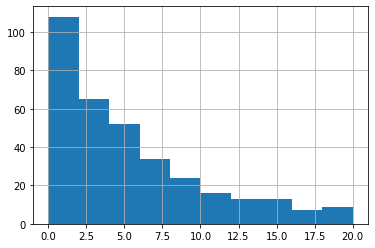

In [6]:
# 3. Проверяем столбец 'absences' на отклонения:
perc25 = stud_math.absences.quantile(0.25)
perc75 = stud_math.absences.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

# Значений ниже -12.0 нет, необходимо убрать все значений выше 20 (они относятся к выбросам):
stud_math = stud_math.loc[stud_math.absences < 21]

# Из гистограммы видно, что выбросы убраны.
stud_math.absences.hist()
stud_math.absences.describe()

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


count    336.000000
mean      51.964286
std       22.731632
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

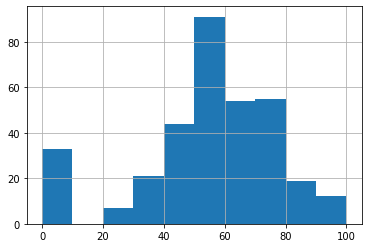

In [7]:
# 3. Проверяем столбец 'score' на отклонения:
perc25 = stud_math.score.quantile(0.25)
perc75 = stud_math.score.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

display(stud_math.score.hist())
display(stud_math.score.describe())

count    303.000000
mean      57.623762
std       15.684082
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

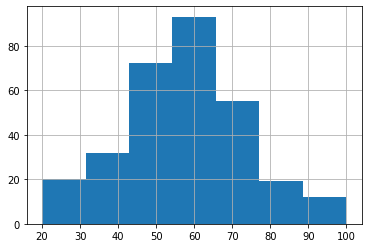

In [8]:
# Все данные укладываются в границы выбросов. Однако посмотрев на гистограмму можно заметить,
# что около 35 человек имеют 0 баллов. Можно предположить, что данные ученики просто не явились на экзамен.
# Поэтому предлагаю их не рассматривать  в данных.

stud_math = stud_math.loc[stud_math.score > 19]

display(stud_math.score.hist(bins = 7, range = (20, 100)))
display(stud_math.score.describe())

# Теперь распеределение оценок учеников больше похожа на реалистичную.

# Удаление NaN

In [9]:
# Подсчитаем в каких столбцах есть пустые значения:
stud_math.isnull().sum(axis = 0)

school         0
sex            0
age            0
address       12
famsize       18
Pstatus       32
Medu           2
Fedu           0
Mjob          14
Fjob          28
reason        15
guardian      27
traveltime    22
studytime      5
failures      15
schoolsup      9
famsup        28
paid          31
activities    12
nursery       12
higher        15
internet      27
romantic      26
famrel        20
freetime       5
goout          6
health        12
absences       0
score          0
dtype: int64

#### Больше всего отсутствует данных в столбцах:
    - Pstatus (статус совместного жилья родителей);
    - paid (дополнительные платные занятия).
    
Скорее всего данные не были собраны в виду своей конфиленциальности, опрашиваемые не хотели оглашать эту информаию)

In [10]:
# Заменяем NaN на None
for i in list(stud_math.columns):
    stud_math[i] = stud_math[i].apply(lambda x: None if pd.isnull(x) else x)

In [11]:
stud_math

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,None,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,None,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,None,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,None,no,yes,yes,yes,None,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,None,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,MS,F,18,U,LE3,T,3.0,1.0,teacher,services,course,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,3.0,4.0,1.0,0.0,40.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,None,1.0,1.0,3.0,None,no,no,no,no,None,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,None,no,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


# Гистограммы распределений

## Age

count    303.000000
mean      16.594059
std        1.216701
min       15.000000
25%       16.000000
50%       16.000000
75%       17.500000
max       21.000000
Name: age, dtype: float64

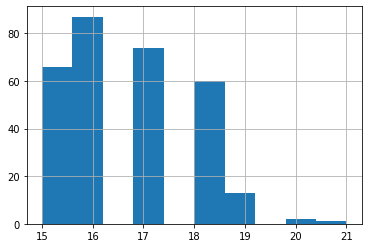

In [12]:
stud_math.age.hist()
stud_math.age.describe()

#### Возраст большинства учеников располагается в диапазоне 16-17 лет

## Medu и Fedu
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

4.0    106
2.0     77
3.0     72
1.0     43
0.0      3
Name: Medu, dtype: int64

2.0    87
3.0    80
4.0    71
1.0    63
0.0     2
Name: Fedu, dtype: int64

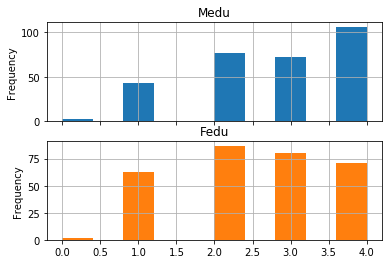

In [13]:
stud_math[['Medu', 'Fedu']].plot(kind = 'hist', 
                               grid = True, 
                               subplots = True, 
                               title = ['Medu', 'Fedu'], 
                               legend = False)
display(stud_math.Medu.value_counts())
display(stud_math.Fedu.value_counts())

#### Распределение степени образования родителей примерно примерно одинаковое. Однако, стоит отметить, что доля матерей с высшим образованием (106 чел.) больше аналогичного показателя у отцов (71 чел.)  

## Traveltime и studytim

1.0    185
2.0     73
3.0     16
4.0      7
Name: traveltime, dtype: int64

2.0    147
1.0     80
3.0     48
4.0     23
Name: studytime, dtype: int64

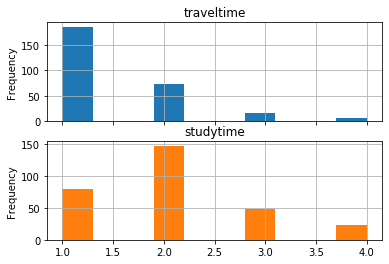

In [14]:
stud_math[['traveltime', 'studytime']].plot(kind = 'hist', 
                               grid = True, 
                               subplots = True, 
                               title = ['traveltime', 'studytime'], 
                               legend = False)
display(stud_math.traveltime.value_counts())
display(stud_math.studytime.value_counts())

#### Большинство учеников затрачивают на дорогу до школы не более 15 минут. Многие ученики тратят на учебу (помимо школы) не более 2,5 часов в неделю.

## failures 

count    288.000000
mean       0.250000
std        0.657309
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

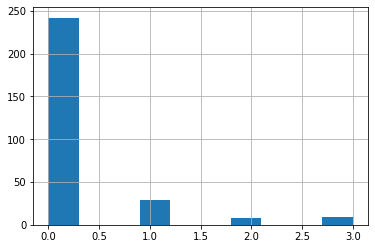

In [15]:
stud_math.failures.hist()
stud_math.failures.describe()

In [16]:
# проверим на выбросы
IQR = stud_math.failures.quantile(0.75) - stud_math.failures.quantile(0.25)
perc25 = stud_math.failures.quantile(0.25)
perc75 = stud_math.failures.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


#### Т.к. большинство значений нахядсят в пределах нуля, тогда для дальнейших значений предположим, что все ученики находятся в равных условиях и не имеют внеучебных неудач.
Удалим столбец failures.

In [17]:
del stud_math['failures']

## famrel

count    283.000000
mean       3.943463
std        0.947366
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

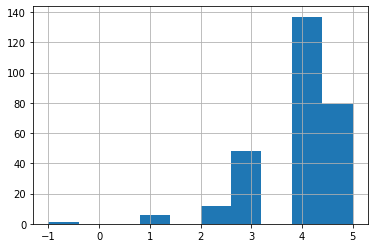

In [18]:
stud_math.famrel.hist()
stud_math.famrel.describe()

#### Подавляющее большинство учеников имеют хорошие семейные отношения (от 4 до 5 ед). В связи с этим крайние выбросы в 1 и -1 единицу предлагаю не учитывать в дальнейшем исследовании, т.к. их частота крайне мала.

In [19]:
stud_math = stud_math.loc[stud_math.famrel > 1]

## freetime

count    271.000000
mean       3.258303
std        1.007231
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

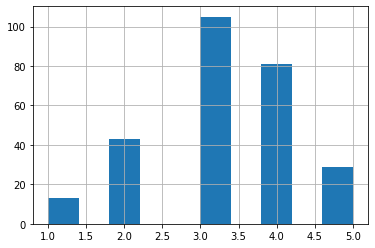

In [23]:
stud_math.freetime.hist()
stud_math.freetime.describe()

В целом распределено нормально, у большинства учеников среднее количество свободного времени вне школы.

## goout

count    270.000000
mean       3.059259
std        1.075326
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

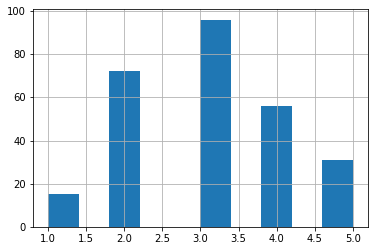

In [24]:
stud_math.goout.hist()
stud_math.goout.describe()

Время проведенное с друзьями распределено нормально. У большинства учеников среднее количество свободного времени вне школы.

## health

count    264.000000
mean       3.534091
std        1.361744
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

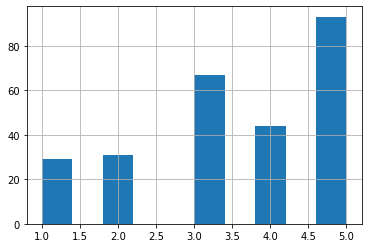

In [28]:
stud_math.health.hist()
stud_math.health.describe()

У большинства учеников среднее состояние здоровья, выбросов не наблюдается.

## absences

count    276.000000
mean       4.927536
std        4.850698
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       20.000000
Name: absences, dtype: float64

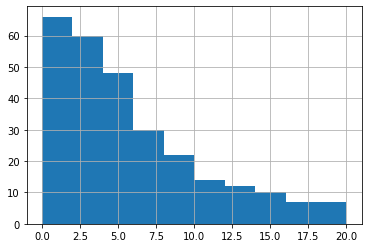

In [82]:
stud_math.absences.hist()
stud_math.absences.describe()

Распределение абсолютно логичное, чем больше пропусков, тем меньше их частота.
Ранее мы убрали отсюда выбросы.

## score

count    276.000000
mean      57.572464
std       15.611598
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

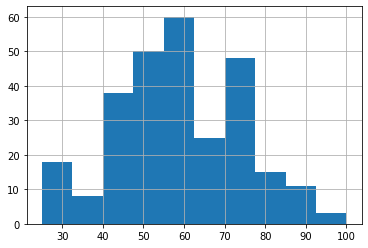

In [85]:
stud_math.score.hist()
stud_math.score.describe()

In [ ]:
Score — это главный столбец, по которому в дальнейшем будет строиться модель.
В целом распределно нормально.

# Корреляционный анализ

(11.0, 0.0)

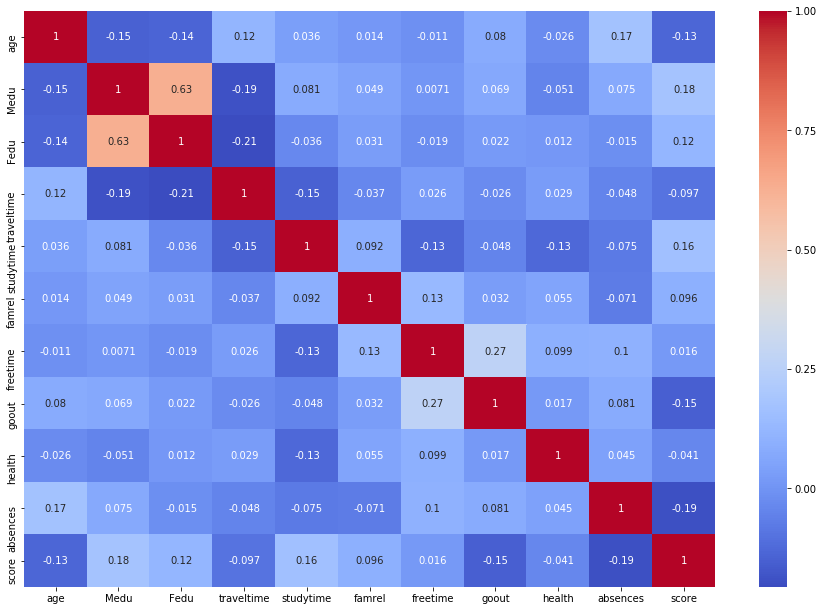

In [48]:
# вычислим коэффициенты корреляции между количественными признаками, содержащимися в датафрейме, с помощью метода corr()
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
correlation = stud_math.corr()
# график табличного вида по корреляции
ax = sns.heatmap(correlation, annot = True, cmap = 'coolwarm')
# Чтобы значения в крайних ячейках нормально отображались
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Из таблицы видно, что наиболее оказывает влияние на итоговый балл по гос экзамену у ученика следующие количественные признаки:
    - Образование родителей (Medu/ k = 0,18; Fedu/ k = 0,12) чем лучше образование у родителей, тем больше они могут помочь в процессе освоения школьного материала своим детям
    - Время на учёбу помимо школы (studytime/ k = 0,16), больше усердий - больше успеваемость (но, это не всегда работает)
    - Семейные отношения (famrel/ k = 0,096), слабо коррелирует, однако хорошие отношения с семьей должны благотворно влиять на успеваемость ребенка

# Анализ номинативных переменных

In [62]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

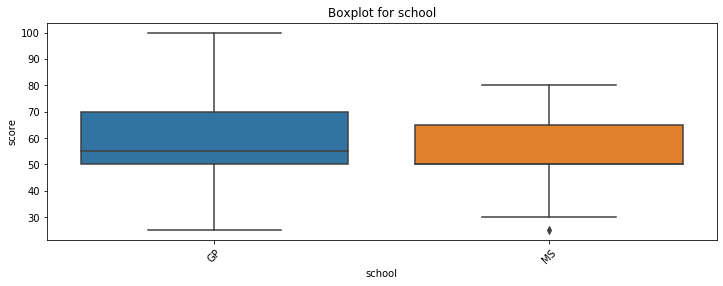

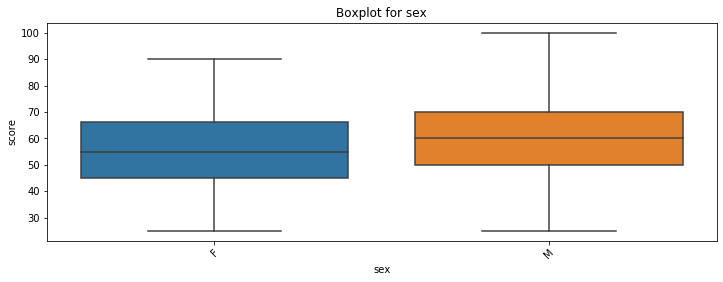

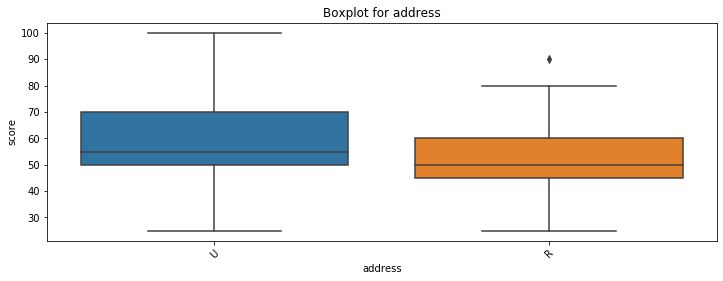

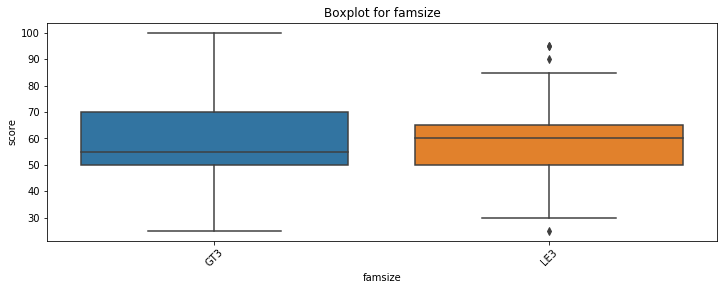

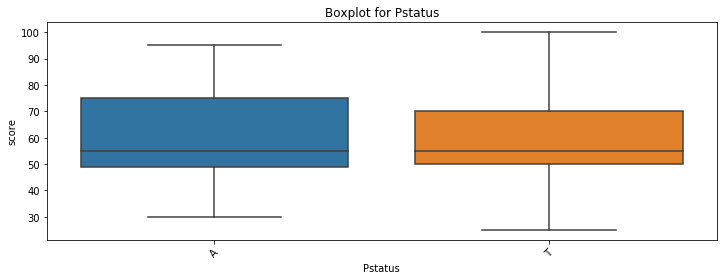

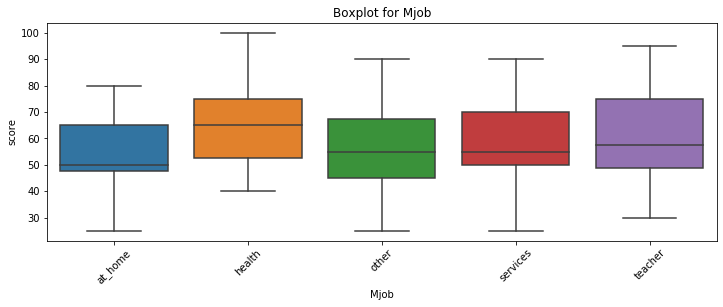

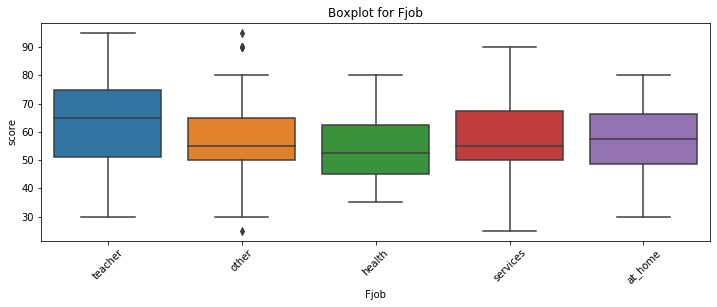

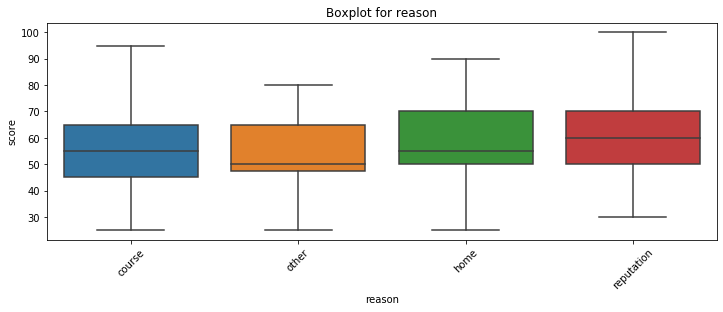

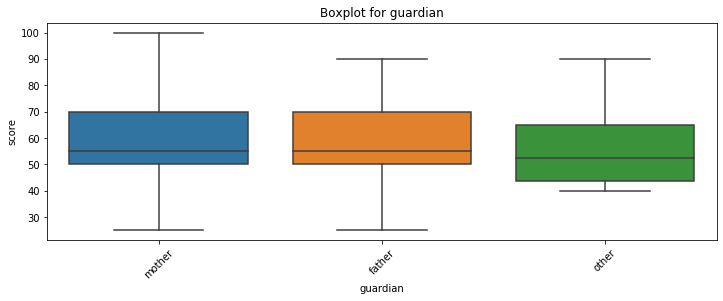

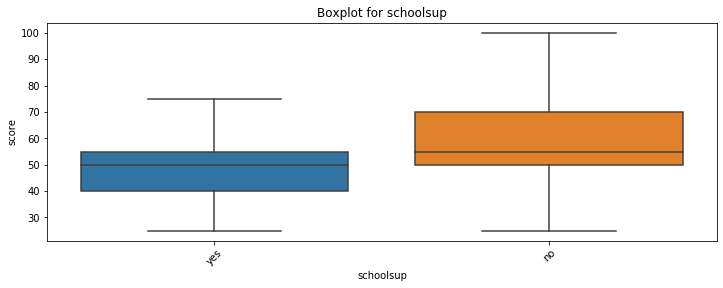

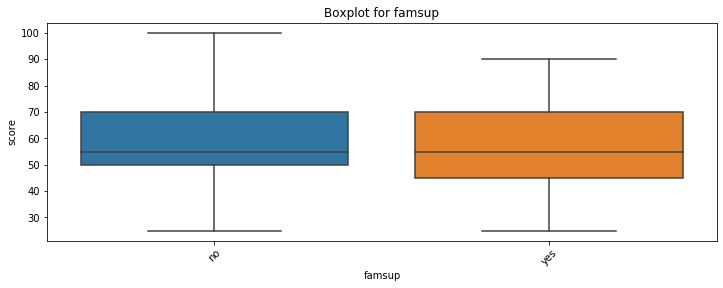

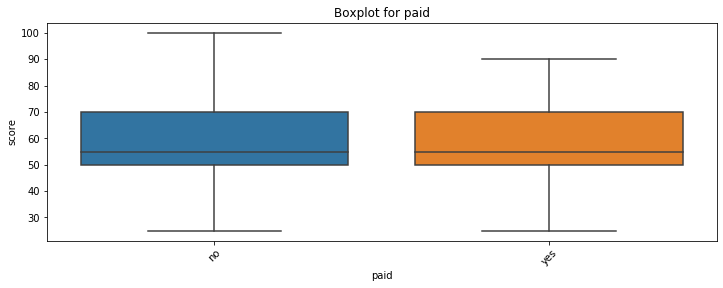

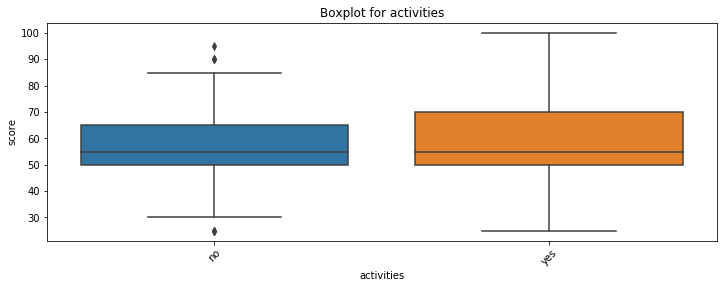

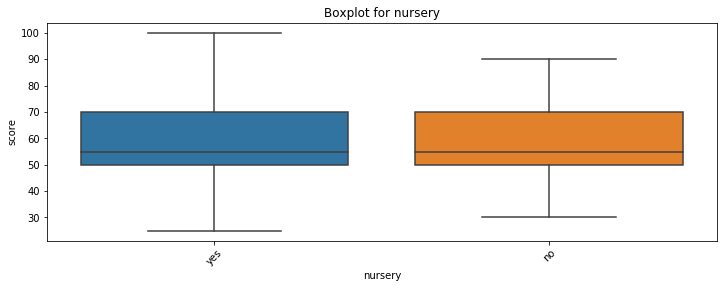

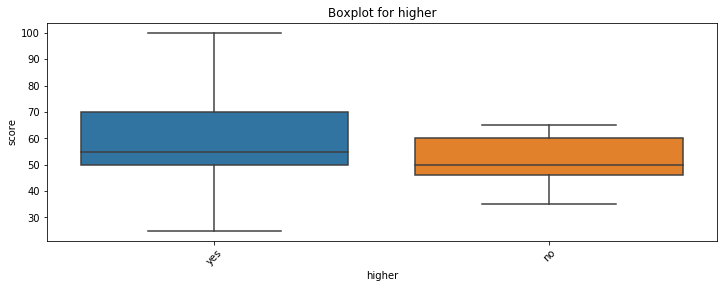

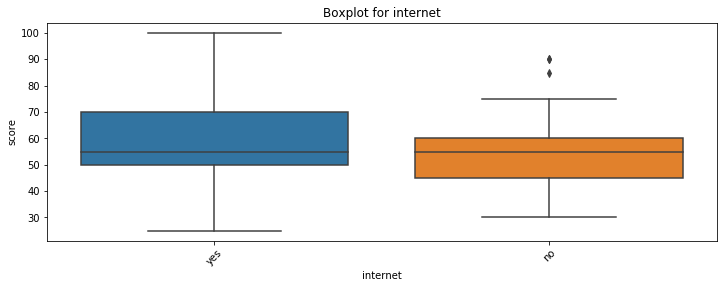

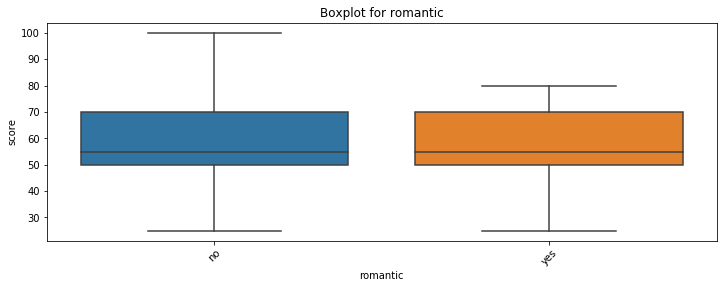

In [65]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob',
            'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_boxplot(col)

# Тест Стьюдента

Проверим H0 о том, что распределение оценок учеников по номинативным признакам неразличимо

In [77]:
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [95]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus','Mjob',
            'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки schoolsup


Отличаются три параметра: address,  Mjob и  schoolsup.
Оставим эти переменные в датасете для дальнейшего построения модели.

Исходя из всего,можно сделать вывод о том, что из всех номинативных переменных наибольшее влияние на итоговую оценку ученика оказывают:

- adress (тем, кто находится в городе приходится меньше тратить времени на дорогу, больше свободного времени, а главное с утра могут позже встать - больше спят - меньше стресса за день)  

- Mjob (два варианта:
    - в семье где мать является учителем успеваемость ребенка выше
    - если мать имеет спокойную не загруженную работу, она может больше времени уделять ребенку)

- schoolsup (предположение: ученики, получающие дополнительную образовательную поддержку это ученики, которые слабо
освоили программу и им требуется помощь. Именно поэтому у таких учеников средняя оценка ниже чем у тех,
кто самостоятельно занимается)

# Итоговый датасет

Что мы имеем по итогу?
Важные переменные, скорее всего оказывающие влияние на оценку, это:
 - 'address'
 - 'Medu'
 - 'Mjob'
 - 'Fedu'
 - 'studytime'
 - 'famrel'
 - 'schoolsup'
 - 'score'

In [104]:
stud_math_for_model = stud_math.loc[:, ['address', 'Medu', 'Mjob', 'Fedu', 'studytime', 'famrel', 'schoolsup', 'score']]
stud_math_for_model

,address,Medu,Mjob,Fedu,studytime,famrel,schoolsup,score
0,U,4.0,at_home,4.0,2.0,4.0,yes,30.0
1,U,1.0,at_home,1.0,2.0,5.0,no,30.0
2,U,1.0,at_home,1.0,2.0,4.0,yes,50.0
3,U,4.0,health,2.0,3.0,3.0,no,75.0
4,U,3.0,other,3.0,2.0,4.0,no,50.0
...,...,...,...,...,...,...,...,...
388,U,3.0,teacher,1.0,2.0,4.0,no,40.0
391,U,3.0,services,1.0,1.0,2.0,no,80.0
392,R,1.0,other,1.0,1.0,5.0,None,35.0
393,R,3.0,services,2.0,1.0,4.0,no,50.0


# Выводы:
    1. В данных множество пропусков, что может говорить о некорректном результате оценки;
    2. Успеваемость ребенка имеет прямую зависимость от образования матери и ее места работы.
       Также на успеваемоть ребенка влияют растояние от дома до школы (адрес проживания) и время
       затрачиваемое на обучение вне школы;
    3. Параметры, предлагаемые для дальнейшего рассмотрения:
       'address', 'Medu', 'Mjob', 'Fedu', 'studytime', 'famrel', 'schoolsup', 'score'